# Mixed-precision quantization of SpeechBrain CRDNN on GPU


This notebook provides code for mixed-precision quantization of the speechbrain/asr-crdnn-rnnlm-librispeech model. We compare base model and different mixed-precision quantized models on the librispeech dataset.

First, let's install `datasets`,  `transformers` and `librosa`.

In [1]:
# %%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install jiwer
!pip install librosa

In [2]:
device = 'cuda'

Next, we install `TensorRT` from source to use its tool `pytorch-quantization` for GPU quantization.

In [3]:
! git clone https://github.com/NVIDIA/TensorRT.git

In [4]:
! cd TensorRT/tools/pytorch-quantization && pip install .

In [5]:
! pip install --upgrade tensorrt

## Prepare Data, Tokenizer, Feature Extractor

In [ ]:
from datasets import load_dataset, load_metric

# Dataset is downloaded from https://www.openslr.org/12
data = load_dataset("LibriSpeech")

In [7]:
# from parse_data import parse_to_json
import json
import os

# parse_to_json("./LibriSpeech/dev-clean")
# os.rename('data.json', 'dev-clean.json')
with open('dev-clean.json', 'r') as file:
    dev_clean_data = json.load(file)

# parse_to_json("./LibriSpeech/test-clean")
# os.rename('data.json', 'test-clean.json')
with open('test-clean.json', 'r') as file:
    test_clean_data = json.load(file)

In [8]:
dev_clean_dict = {}
for key, value in dev_clean_data.items():
    new_key = key.replace('-', '')
    dev_clean_dict[new_key] = value

In [9]:
test_clean_dict = {}
for key, value in test_clean_data.items():
    new_key = key.replace('-', '')
    test_clean_dict[new_key] = value

In [10]:
import soundfile as sf
import resampy

def flac_to_array_with_sampling_rate(file_path, target_sr=16000):
    data, sr = sf.read(file_path, dtype='float32')

    if sr != target_sr:
        data = resampy.resample(data, sr, target_sr)

    return data

In [11]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_dev(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(dev_clean_dict[words[0]]['file_path'])
    return batch

In [ ]:
data['validation'] = data['validation'].map(remove_special_characters_dev)

In [13]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_test(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(test_clean_dict[words[0]]['file_path'])
    return batch

In [ ]:
data['test'] = data['test'].map(remove_special_characters_test)

## Base Model

In [15]:
from speechbrain.pretrained import EncoderDecoderASR

In [16]:
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [17]:
import torch
with torch.no_grad():
    features = asr_model.mods.encoder.compute_features(torch.tensor(data['validation'][:1]['input_values']).cuda())

In [ ]:
torch.onnx.export(asr_model.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder_librispeech.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

## Mixed-precision Quantization

In [19]:
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [20]:
eight_bits_all_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})
four_bits_all_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})
four_bits_cnn_eight_bits_dnn_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})
eight_bits_cnn_four_bits_dnn_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [21]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [22]:
quant_modules.initialize()
eight_bits_all_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [23]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=4, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [24]:
quant_modules.initialize()
four_bits_all_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [25]:
quant_desc_input_4bits = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_desc_input_8bits = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight_4bits = QuantDescriptor(num_bits=4, axis=(0))
quant_desc_weight_8bits = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input_4bits)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight_4bits)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input_8bits)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight_8bits)

In [26]:
quant_modules.initialize()
four_bits_cnn_eight_bits_dnn_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [27]:
quant_desc_input_4bits = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_desc_input_8bits = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight_4bits = QuantDescriptor(num_bits=4, axis=(0))
quant_desc_weight_8bits = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input_8bits)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight_8bits)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input_4bits)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight_4bits)

In [28]:
quant_modules.initialize()
eight_bits_cnn_four_bits_dnn_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [29]:
for name, module in eight_bits_all_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant()

In [30]:
for name, module in four_bits_all_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant()

In [31]:
for name, module in four_bits_cnn_eight_bits_dnn_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant()

In [32]:
for name, module in eight_bits_cnn_four_bits_dnn_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant()

In [ ]:
import torch
with torch.no_grad():
    for i in range(2000):
            _ = eight_bits_all_model_full_quantized(torch.tensor(data['validation'][i:i+1]["input_values"]).cuda(), torch.tensor([1.0]).to('cuda'))
            _ = four_bits_all_model_full_quantized(torch.tensor(data['validation'][i:i+1]["input_values"]).cuda(), torch.tensor([1.0]).to('cuda'))
            _ = four_bits_cnn_eight_bits_dnn_model_full_quantized(torch.tensor(data['validation'][i:i+1]["input_values"]).cuda(), torch.tensor([1.0]).to('cuda'))
            _ = eight_bits_cnn_four_bits_dnn_model_full_quantized(torch.tensor(data['validation'][i:i+1]["input_values"]).cuda(), torch.tensor([1.0]).to('cuda'))

In [34]:
# Finalize calibration

for name, module in eight_bits_all_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

eight_bits_all_model_full_quantized.cuda()

W1228 00:37:07.509674 140602819461120 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([128, 1, 1, 1]).
W1228 00:37:07.511168 140602819461120 tensor_quantizer.py:239] Call .cuda() if running on GPU after loading calibrated amax.
W1228 00:37:07.511857 140602819461120 tensor_quantizer.py:174] Disable MaxCalibrator
W1228 00:37:07.512352 140602819461120 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([128, 1, 1, 1]).
W1228 00:37:07.512862 140602819461120 tensor_quantizer.py:174] Disable MaxCalibrator
W1228 00:37:07.513362 140602819461120 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([256, 1, 1, 1]).
W1228 00:37:07.513759 140602819461120 tensor_quantizer.py:174] Disable MaxCalibrator
W1228 00:37:07.514129 140602819461120 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([256, 1, 1, 1]).
W1228 00:37:07.514448 140602819461120 tensor_quantizer.py:174] Disable MaxCalibrator
W1228 00:37:07.514830 140602819461120 tensor_quantizer.py:2

EncoderDecoderASR(
  (mods): ModuleDict(
    (normalizer): InputNormalization()
    (encoder): LengthsCapableSequential(
      (compute_features): Fbank(
        (compute_STFT): STFT()
        (compute_fbanks): Filterbank()
        (compute_deltas): Deltas()
        (context_window): ContextWindow()
      )
      (normalize): InputNormalization()
      (model): CRDNN(
        (CNN): Sequential(
          (block_0): CNN_Block(
            (conv_1): Conv2d(
              (conv): QuantConv2d(
                1, 128, kernel_size=(3, 3), stride=(1, 1)
                (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.1787, 0.7642](128) calibrator=MaxCalibrator scale=1.0 quant)
              )
            )
            (norm_1): LayerNorm(
              (norm): LayerNorm((40, 128), eps=1e-05, elementwise_affine=True)
            )
            (act_1): Lea

In [ ]:
for name, module in four_bits_all_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

four_bits_all_model_full_quantized.cuda()

In [ ]:
for name, module in four_bits_cnn_eight_bits_dnn_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

four_bits_cnn_eight_bits_dnn_model_full_quantized.cuda()

In [ ]:
for name, module in eight_bits_cnn_four_bits_dnn_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

eight_bits_cnn_four_bits_dnn_model_full_quantized.cuda()

In [38]:
eight_bits_all_model_full_quantized.mods.encoder.model.DNN = eight_bits_all_model_full_quantized.mods.encoder.model.DNN
eight_bits_all_model_full_quantized.mods.encoder.model.CNN = eight_bits_all_model_full_quantized.mods.encoder.model.CNN

four_bits_all_model_quantized.mods.encoder.model.DNN = four_bits_all_model_full_quantized.mods.encoder.model.DNN
four_bits_all_model_quantized.mods.encoder.model.CNN = four_bits_all_model_full_quantized.mods.encoder.model.CNN

four_bits_cnn_eight_bits_dnn_model_quantized.mods.encoder.model.DNN = four_bits_cnn_eight_bits_dnn_model_full_quantized.mods.encoder.model.DNN
four_bits_cnn_eight_bits_dnn_model_quantized.mods.encoder.model.CNN = four_bits_cnn_eight_bits_dnn_model_full_quantized.mods.encoder.model.CNN

eight_bits_cnn_four_bits_dnn_model_quantized.mods.encoder.model.DNN = eight_bits_cnn_four_bits_dnn_model_full_quantized.mods.encoder.model.DNN
eight_bits_cnn_four_bits_dnn_model_quantized.mods.encoder.model.CNN = eight_bits_cnn_four_bits_dnn_model_full_quantized.mods.encoder.model.CNN

In [39]:
torch.onnx.export(eight_bits_all_model_quantized.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder-eight_bits_all_model_quantized_librispeech.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [ ]:
torch.onnx.export(four_bits_all_model_quantized.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder-four_bits_all_model_quantized_librispeech.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [41]:
torch.onnx.export(four_bits_cnn_eight_bits_dnn_model_quantized.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder-four_bits_cnn_eight_bits_dnn_model_quantized_librispeech.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [42]:
torch.onnx.export(eight_bits_cnn_four_bits_dnn_model_quantized.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder-eight_bits_cnn_four_bits_dnn_model_quantized_librispeech.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

### Base vs Quantized Model Inference Time

In this section, we compare the inference time of the base model and the quantized model on the test data. Furthermore, we evalute the perfomance of the base and the quantized models using the word error rate (WER) metric.

**Inference**

In [ ]:
# ! pip install onnxruntime-gpu

In [44]:
import onnxruntime as ort
import tensorrt
ort.get_device()

'GPU'

In [ ]:
# Load onnx models
ort_sess_eight_bits_all_model_quantized = ort.InferenceSession('asr-crdnn-encoder-eight_bits_all_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_four_bits_all_model_quantized = ort.InferenceSession('asr-crdnn-encoder-four_bits_all_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_four_bits_cnn_eight_bits_dnn_model_quantized = ort.InferenceSession('asr-crdnn-encoder-four_bits_cnn_eight_bits_dnn_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_eight_bits_cnn_four_bits_dnn_model_quantized = ort.InferenceSession('asr-crdnn-encoder-eight_bits_cnn_four_bits_dnn_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_base = ort.InferenceSession('asr-crdnn-encoder.onnx')

In [46]:
import time
import numpy

def compute_inference_time(ort_sess, num_samples):
    model_time = 0
    with torch.no_grad():
        for single_batch in data["test"].select(range(num_samples)):
            initial_input = torch.tensor([single_batch["input_values"]]).cuda()
            features_input = asr_model.mods.encoder.compute_features(initial_input)
            input_values = torch.tensor(features_input, device="cpu")
            input_values = input_values.clone().detach().numpy().astype(numpy.float32)
            starttime = time.time()
            ort_sess.run(['modelOutput'], {'modelInput': input_values})
            model_time += time.time() - starttime
    return round(model_time/num_samples, 8)

In [47]:
num_samples = 50

base_model_time = compute_inference_time(ort_sess_base, num_samples)

/tmp/ipykernel_111919/317541760.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_values = torch.tensor(features_input, device="cpu")


In [48]:
print(f'Base Model inference time {base_model_time} seconds')

Base Model inference time 0.41006503 seconds


In [62]:
ort_sess_eight_bits_all_model_quantized_time = compute_inference_time(ort_sess_eight_bits_all_model_quantized, num_samples)

/tmp/ipykernel_111919/317541760.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_values = torch.tensor(features_input, device="cpu")


In [63]:
print(f'Quantized Model, all layers with 8 bits, inference time {ort_sess_eight_bits_all_model_quantized_time} seconds')

Quantized Model, all layers with 8 bits, inference time 0.17263575 seconds


In [64]:
ort_sess_four_bits_all_model_quantized_time = compute_inference_time(ort_sess_four_bits_all_model_quantized, num_samples)

/tmp/ipykernel_111919/317541760.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_values = torch.tensor(features_input, device="cpu")


In [65]:
print(f'Quantized Model, all layers with 4 bits, inference time {ort_sess_four_bits_all_model_quantized_time} seconds')

Quantized Model, all layers with 4 bits, inference time 0.17029206 seconds


In [66]:
ort_sess_four_bits_cnn_eight_bits_dnn_model_quantized_time = compute_inference_time(ort_sess_four_bits_cnn_eight_bits_dnn_model_quantized, num_samples)

/tmp/ipykernel_111919/317541760.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_values = torch.tensor(features_input, device="cpu")


In [67]:
print(f'Quantized Model, 4 bits cnn and 8 bits dnn, inference time {ort_sess_four_bits_cnn_eight_bits_dnn_model_quantized_time} seconds')

Quantized Model, 4 bits cnn and 8 bits dnn, inference time 0.17066881 seconds


In [68]:
ort_sess_eight_bits_cnn_four_bits_dnn_model_quantized_time = compute_inference_time(ort_sess_eight_bits_cnn_four_bits_dnn_model_quantized, num_samples)

/tmp/ipykernel_111919/317541760.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_values = torch.tensor(features_input, device="cpu")


In [69]:
print(f'Quantized Model, 8 bits cnn and 4 bits dnn, inference time {ort_sess_eight_bits_cnn_four_bits_dnn_model_quantized_time} seconds')

Quantized Model, 8 bits cnn and 4 bits dnn, inference time 0.17050085 seconds


**Inference Time Visualisation of Results**

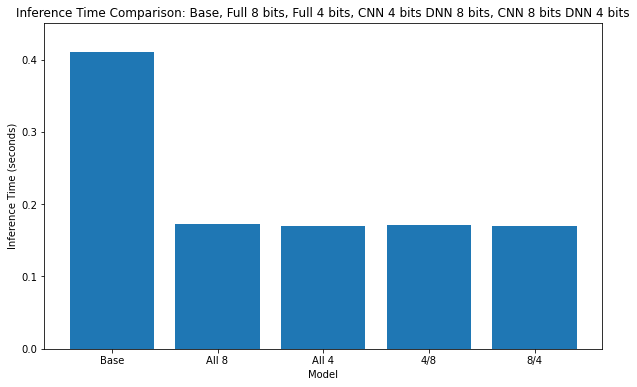

In [70]:
import matplotlib.pyplot as plt

models = ['Base', 'All 8', 'All 4', '4/8', '8/4']
inference_times = [base_model_time, ort_sess_eight_bits_all_model_quantized_time, ort_sess_four_bits_all_model_quantized_time, ort_sess_four_bits_cnn_eight_bits_dnn_model_quantized_time, ort_sess_eight_bits_cnn_four_bits_dnn_model_quantized_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base, Full 8 bits, Full 4 bits, CNN 4 bits DNN 8 bits, CNN 8 bits DNN 4 bits')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

**Evaluating WER metric**

In [ ]:
wer_metric = load_metric("wer")

In [ ]:
def map_model_to_wer_result(model, single_batch):
    input_values = torch.tensor(single_batch["input_values"]).to('cuda')
    with torch.no_grad():
        prediction = model(input_values, torch.tensor([1.0]).to('cuda'))

    return wer_metric.compute(predictions=[prediction[0][0].lower()], references=single_batch['text'])

In [ ]:
num_samples = len(data['test'])

In [ ]:
total_wer = 0

for i in range(num_samples):
    total_wer += map_model_to_wer_result(asr_model, data['test'][i:i+1])

base_wer_result = round(total_wer / num_samples, 8)

In [ ]:
print(f'Base Model WER: {base_wer_result}')

Base Model WER: 0.03510307


In [ ]:
total_wer_eight_bits_all_model_quantized = 0

for i in range(num_samples):
    total_wer_eight_bits_all_model_quantized += map_model_to_wer_result(eight_bits_all_model_quantized,  data['test'][i:i+1])

eight_bits_all_model_quantized_wer_result = round(total_wer_eight_bits_all_model_quantized / num_samples, 8)

In [ ]:
print(f'Quantized Model, all layers with 8 bits, WER: {eight_bits_all_model_quantized_wer_result}')

Quantized Model, all layers with 8 bits, WER: 0.03510307


In [ ]:
total_wer_four_bits_all_model_quantized = 0

for i in range(num_samples):
    total_wer_four_bits_all_model_quantized += map_model_to_wer_result(four_bits_all_model_quantized,  data['test'][i:i+1])

total_wer_four_bits_all_model_quantized_wer_result = round(total_wer_four_bits_all_model_quantized / num_samples, 8)

In [ ]:
print(f'Quantized Model, all layers with 4 bits, WER: {total_wer_four_bits_all_model_quantized_wer_result}')

Quantized Model, all layers with 4 bits, WER: 0.04352292


In [ ]:
total_four_bits_cnn_eight_bits_dnn_model_quantized = 0

for i in range(num_samples):
    total_four_bits_cnn_eight_bits_dnn_model_quantized += map_model_to_wer_result(four_bits_cnn_eight_bits_dnn_model_quantized,  data['test'][i:i+1])

four_bits_cnn_eight_bits_dnn_model_quantized_wer_result = round(total_four_bits_cnn_eight_bits_dnn_model_quantized / num_samples, 8)

In [ ]:
print(f'Quantized Model, 4 bits CNN and 8 bits DNN, WER: {four_bits_cnn_eight_bits_dnn_model_quantized_wer_result}')

Quantized Model, 4 bits CNN and 8 bits DNN, WER: 0.03749499


In [ ]:
total_eight_bits_cnn_four_bits_dnn_model_quantized = 0

for i in range(num_samples):
    total_eight_bits_cnn_four_bits_dnn_model_quantized += map_model_to_wer_result(eight_bits_cnn_four_bits_dnn_model_quantized,  data['test'][i:i+1])

eight_bits_cnn_four_bits_dnn_model_quantized_wer_result = round(total_eight_bits_cnn_four_bits_dnn_model_quantized / num_samples, 8)

In [ ]:
print(f'Quantized Model, 8 bits CNN and 4 bits DNN, WER: {eight_bits_cnn_four_bits_dnn_model_quantized_wer_result}')

Quantized Model, 8 bits CNN and 4 bits DNN, WER: 0.04352292


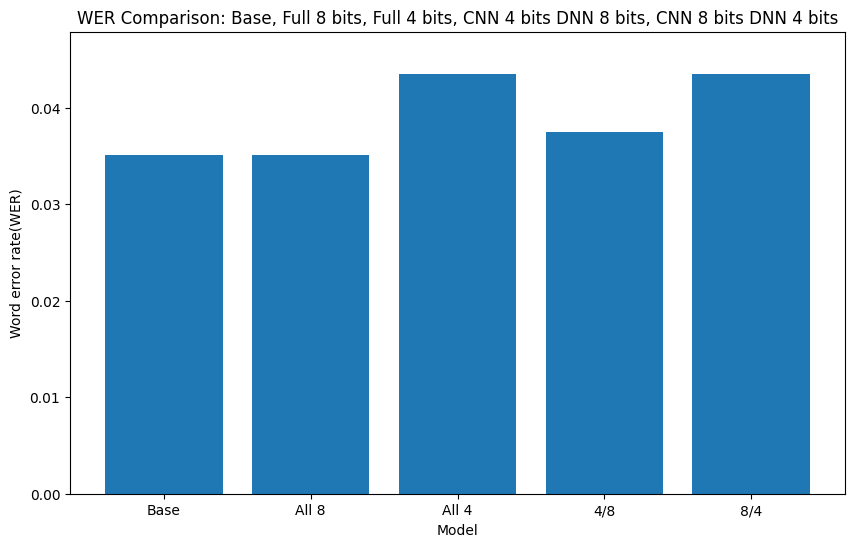

In [ ]:
import matplotlib.pyplot as plt

models = ['Base', 'All 8', 'All 4', '4/8', '8/4']
inference_times = [base_wer_result, eight_bits_all_model_quantized_wer_result, total_wer_four_bits_all_model_quantized_wer_result, four_bits_cnn_eight_bits_dnn_model_quantized_wer_result, eight_bits_cnn_four_bits_dnn_model_quantized_wer_result]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Word error rate(WER)')
plt.title('WER Comparison: Base, Full 8 bits, Full 4 bits, CNN 4 bits DNN 8 bits, CNN 8 bits DNN 4 bits')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()